In [2]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt


import nltk
from nltk.corpus import stopwords
# import spacy

import time
import string


# from sklearn.

# MODELS
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

# EVALUATION METRICS and TOOLS
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import classification_report


# OTHER TOOLS
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import  HalvingGridSearchCV, RepeatedStratifiedKFold, cross_val_score, train_test_split

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from utils import main as utils

In [3]:
df, X_train, X_test, y_train, y_test, feature_names, target_names = utils.load_dataset('data/splitted_data.csv', 
                                                                                       sample=5000,
                                                                                       verbose=True)

/home/hasan/.virtualenvs/thesis/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


5000 documents - 3.14MB (training set)
15 categories
vectorize training done in 1.534s at 2.045MB/s
n_samples: 4000, n_features: 6521
n_samples: 1000, n_features: 6521


In [4]:
# Train a Random Forest model
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)

RandomForestClassifier()

In [5]:

pred = clf.predict(X_test)

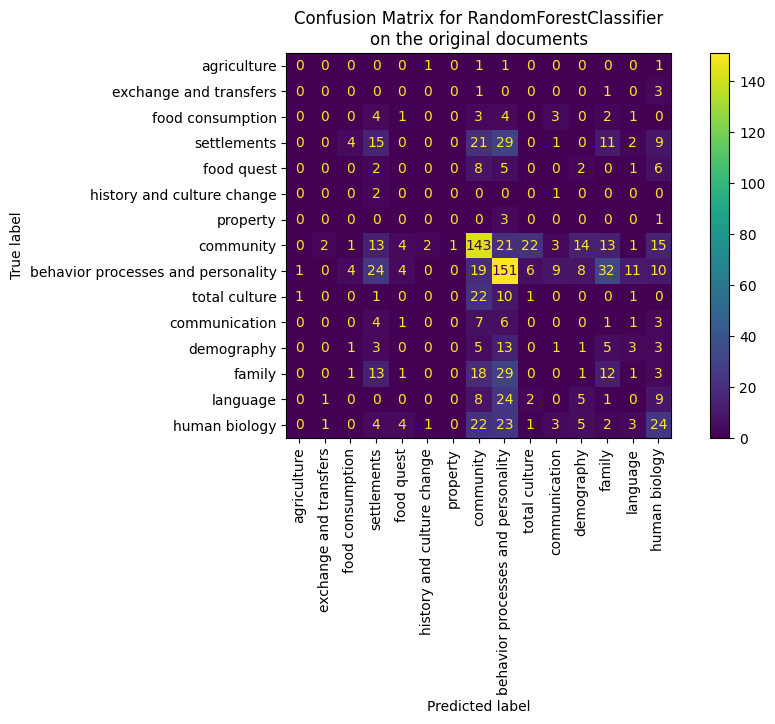

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(10, 5))
ConfusionMatrixDisplay.from_predictions(y_test, pred, ax=ax)
ax.xaxis.set_ticklabels(target_names, rotation = 90)
ax.yaxis.set_ticklabels(target_names)
_ = ax.set_title(
    f"Confusion Matrix for {clf.__class__.__name__}\non the original documents"
)

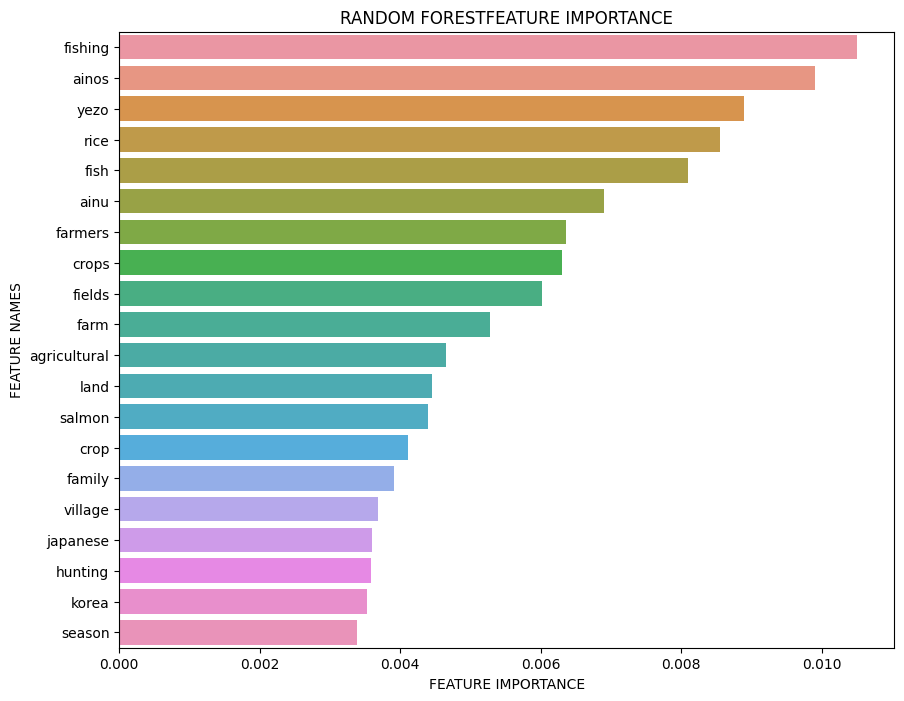

In [16]:
def plot_feature_importance(importance, names, model_type):
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    fi_df = fi_df[:20]
    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

plot_feature_importance(clf.feature_importances_, feature_names,'RANDOM FOREST')


In [2]:
# Load data from CSV file
df = pd.read_csv("data/splitted_data.csv")

In [3]:
SELECTED = 10000

Since some categories have very few instances and the fact that the data is quite large, I could most likely balance the samples.

In [4]:
# CHECK OUT: 310, 340, 400, 520, 570, 580, 870] activities, building structures, machines, recreation, interpersonal relations, marriage, education.
chosen_categories = [140, 150, 160, 170, 180, 190, 200, 220, 240, 260, 360, 420, 430, 590, 620]#, 780, 820]

In [73]:
data = df[df['parent_ocms'].isin(chosen_categories)]

In [6]:
data.shape

(366157, 13)

In [7]:
data = data.sample(SELECTED)

In [8]:
data.shape

(10000, 13)

In [237]:
# train = data.sample(SELECTED)
# test  = data.sample(SELECTED)

In [90]:
data.groupby('parent_ocms').count()['textrecord'].nlargest(30)

parent_ocms
240    98179
220    93017
430    32559
170    29994
620    21736
420    20723
260    17013
180    11185
590    10745
360     9968
160     6769
190     6211
150     5038
200     1578
140     1442
Name: textrecord, dtype: int64

In [91]:
# same samples
minimum = 1442
data = []
for cat in chosen_categories:
    data.append(df[df['parent_ocms'] == cat][:minimum])

In [99]:
data = pd.concat(data)

In [100]:
data.groupby('parent_ocms').count()['textrecord'].nlargest(30)

parent_ocms
140    1442
150    1442
160    1442
170    1442
180    1442
190    1442
200    1442
220    1442
240    1442
260    1442
360    1442
420    1442
430    1442
590    1442
620    1442
Name: textrecord, dtype: int64

In [302]:
low_keys = list(df[SELECTED:SELECTED*2].groupby('ocms').count()['textrecord'].nsmallest(200).keys())

In [303]:
low_keys.append(241)

In [304]:
data = df[SELECTED:SELECTED*2][~df[SELECTED:SELECTED*2]['ocms'].isin(low_keys)]

In [ ]:
data.iloc[5889].textrecord

'each farmer takes the labor capacity of his family into consideration in planning the use of his land.'

In [111]:
stop_words = set(stopwords.words('english'))

def unneeded_tokens(tokens):
    unneeded = ['table', 'graphic']
    return [token for token in tokens if not token in unneeded]

def insufficient_info(text : str):
    text = text.strip()
    if text.startswith('~') and text.endswith('~'):
        return True
    return

def remove_punct(token):
    return re.sub(r'[^\w\s]', '', token)
    
# turn a doc into clean tokens
def clean_doc(doc):
    if insufficient_info(doc):
        return []
    # print(doc)
    # doc = re.sub(r'[^\w\s]', '', doc)
    # print(doc)
    # split into tokens by white space
    tokens = doc.split()
    
    # filter out edge-case words.
    # tokens = unneeded_tokens(tokens)
    
    # remove punctuation from each token
    table = str.maketrans('', '', string.punctuation)
    tokens = [w.translate(table) if not remove_punct(w).isnumeric() else w 
              for w in tokens]
    
    # filter out stop words
    # tokens = [w for w in tokens if not remove_punct(w).lower() in stop_words]
    tokens = [w for w in tokens if not w in stop_words]
    
    # remove remaining tokens that are not alphabetic or numeric
    tokens = [word  for word in tokens if remove_punct(word).isalpha()
              # or word.replace('.', '',).replace(',', '').isnumeric()]
              or word.isnumeric()]
    # remove punctuation of actual words; like apostrophies'
    tokens = [remove_punct(word) if remove_punct(word).isalpha() else word  for word in tokens]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 1]
    
    return tokens

In [ ]:
print(list(text_vec.get_feature_names_out()))

In [112]:
s = time.time()

tfidf_vec = TfidfVectorizer(min_df=3, # If a token appears fewer times than this, across all documents, it will be ignored
                             # tokenizer=nltk.word_tokenize, # we use the nltk tokenizer
                             tokenizer=clean_doc, # we use the custom tokenizer
                             stop_words='english')#stopwords.words('english')) # stopwords are removed

tfidf_text = tfidf_vec.fit_transform(data['textrecord'])


e = time.time()
print("Elapsed time during the whole program in seconds:",
                                         e-s) 

/home/hasan/.virtualenvs/thesis/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Elapsed time during the whole program in seconds: 6.37122106552124


In [114]:
print('Total number of words in our data:', len(tfidf_vec.vocabulary_))

Total number of words in our data: 23737


In [115]:
print(list(tfidf_vec.get_feature_names_out()))

['000', '10', '100', '1000', '101', '102', '103', '104', '105', '106', '107', '108', '109', '11', '110', '111', '112', '1122', '113', '114', '115', '117', '118', '119', '12', '120', '1200', '121', '122', '123', '1249', '125', '126', '127', '128', '129', '1292', '13', '130', '1300', '131', '132', '134', '135', '136', '137', '139', '14', '140', '1401', '141', '142', '143', '144', '145', '146', '147', '148', '15', '150', '1500', '150646', '150647', '150648', '150651', '150652', '150654', '150655', '150657', '150658', '150660', '150661', '150666', '150669', '150670', '150672', '150674', '150676', '150677', '150678', '150682', '150685', '150686', '150689', '150690', '150691', '150692', '150700', '150703', '150704', '150707', '150709', '150710', '150711', '150712', '150713', '150715', '150717', '150718', '150721', '150724', '150727', '150728', '150729', '150731', '150734', '150737', '150738', '150739', '150742', '150743', '150744', '150745', '150746', '150748', '150749', '150751', '150752', 

In [116]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(tfidf_text, data['parent_ocms'], test_size=0.2)

In [99]:
X_train.toarray()[0]

array([0, 0, 0, ..., 0, 0, 0])

# Random Forest

In [87]:
clf = RandomForestClassifier(random_state=0)
# cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3)

param_grid = {"max_depth": [3, None],
              "min_samples_split": [5, 10],}

search = HalvingGridSearchCV(clf, param_grid, resource='n_estimators',
                             max_resources=10,
                             cv=5,
                             random_state=0).fit(X_train, y_train)
search.best_params_  

{'max_depth': None, 'min_samples_split': 10, 'n_estimators': 9}

In [89]:
search.best_estimator_.score(X_test, y_test)

0.3549950841162333

In [117]:
# Train a Random Forest model
model = RandomForestClassifier(n_estimators=100)
model.fit(X_train, y_train)

RandomForestClassifier()

In [ ]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3)

n_scores = cross_val_score(model, 
                           tfidf_text, data['parent_ocms'], 
                           scoring='accuracy', 
                           cv=cv, 
                           n_jobs=-1, 
                           error_score='raise')

In [ ]:

print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

In [118]:
# Evaluate the model on the testing set
accuracy = model.score(X_test, y_test)
print("Accuracy:", accuracy)

Accuracy: 0.3791030975496995


In [355]:
# Evaluate the model on the testing set
accuracy = rf.score(X_test, y_test)
print("Accuracy:", accuracy)

Accuracy: 0.6417910447761194


In [57]:
preds = rf.predict(X_test)
print(preds)

[240 220 240 ... 240 220 240]


In [ ]:
report = classification_report(y_test, preds, digits = 3)
print(report)

In [268]:
_test = df['textrecord'][SELECTED*2:SELECTED*3]
_test = text_vec.transform(_test)

In [ ]:
rf.predict(_test)[100:300]

In [ ]:
# Evaluate the model on the testing set
accuracy = rf.score(X_test, y_test)
print("Accuracy:", accuracy)

# Logisitc Regression

In [39]:

pipe = make_pipeline(StandardScaler(with_mean=False), LogisticRegression(max_iter=10000))

In [36]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(tfidf_text, data['parent_ocms'], test_size=0.2)

In [37]:
pipe.fit(X_train, y_train)

/home/hasan/.virtualenvs/thesis/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('standardscaler', StandardScaler(with_mean=False)),
                ('logisticregression',
                 LogisticRegression(C=10, max_iter=1000))])

In [38]:
pipe.score(X_test, y_test)

0.3655

In [27]:
clf.score(X_test, y_test)

0.452

In [27]:
clf.score(X_test, y_test)

0.452

In [ ]:
clf.predict(X[:2, :])

In [ ]:
clf.predict_proba(X[:2, :]).shape

# KNN

In [46]:
k_values = [i for i in range (1,31)]
scores = []

scaler = StandardScaler(with_mean=False)
X = scaler.fit_transform(X_train)

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    score = cross_val_score(knn, X, y_train, cv=5)
    scores.append(np.mean(score))

NameError: name 'plt' is not defined

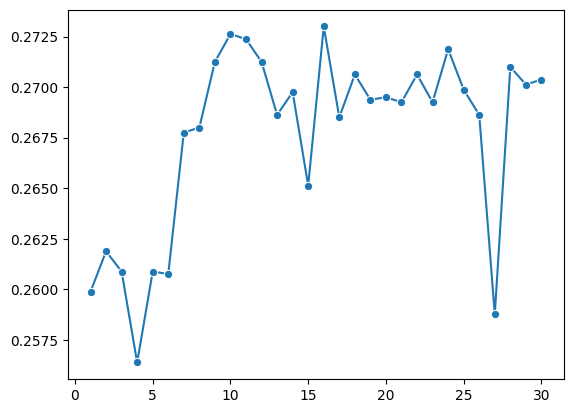

In [48]:
sns.lineplot(x = k_values, y = scores, marker = 'o')
plt.xlabel("K Values")
plt.ylabel("Accuracy Score")

In [70]:
pipe = make_pipeline(StandardScaler(with_mean=False),
                     KNeighborsClassifier(n_neighbors=16))

In [71]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler(with_mean=False)),
                ('kneighborsclassifier', KNeighborsClassifier(n_neighbors=16))])

In [72]:
pipe.score(X_test, y_test)

0.292

In [2]:
nlp = spacy.load("en_core_web_sm")

In [13]:
# Define a function to preprocess a text record
def preprocess_text(text):
    doc = nlp(text)
    tokens = [token.lemma_.lower().strip() for token in doc 
              if not token.is_stop and not token.is_punct and token.lemma_ != '-PRON-']
    return tokens

In [14]:
s = time.time()

# Apply the preprocess_text function to the textrecord column
df["processed_text"] = df["textrecord"].apply(preprocess_text)

    
e = time.time()


print("Elapsed time during the whole program in seconds:",
                                         e-s) 

KeyboardInterrupt: 

In [ ]:
df.to_csv('data/splitted_preprocessed.csv')

In [ ]:
s = time.time()

nlp.pipe(df["textrecord"])


e = time.time()


print("Elapsed time during the whole program in seconds:",
                                         e-s) 

In [ ]:
# Preprocess data (e.g., remove missing values, encode categorical variables)

for doc in nlp.pipe(texts):
    # Do something with the doc here
    print([(ent.text, ent.label_) for ent in doc.ents])

    

Elapsed time during the whole program in seconds: 1.9375221729278564


In [ ]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data.drop("dependency_strength", axis=1), data["dependency_strength"], test_size=0.2)

In [ ]:
# Train a Random Forest model
rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf.fit(X_train, y_train)

In [ ]:
# Evaluate the model on the testing set
accuracy = rf.score(X_test, y_test)
print("Accuracy:", accuracy)

# Links
- https://www.datacamp.com/tutorial/random-forests-classifier-python
- https://machinelearningmastery.com/random-forest-ensemble-in-python/
- https://github.com/WillKoehrsen/Data-Analysis/tree/master/random_forest_explained
- https://www.kdnuggets.com/2017/06/7-techniques-handle-imbalanced-data.html
- https://towardsdatascience.com/methods-for-dealing-with-imbalanced-data-5b761be45a18
- **GREAT RESOURCE** https://scikit-learn.org/stable/auto_examples/text/plot_document_classification_20newsgroups.html#sphx-glr-auto-examples-text-plot-document-classification-20newsgroups-py
- https://scikit-learn.org/stable/modules/ensemble.html#subsampling

In [ ]:
# # Export the first three decision trees from the forest

# for i in range(3):
#     tree = rf.estimators_[i]
#     dot_data = export_graphviz(tree,
#                                feature_names=X_train.columns,  
#                                filled=True,  
#                                max_depth=2, 
#                                impurity=False, 
#                                proportion=True)
#     graph = graphviz.Source(dot_data)
#     display(graph)